## Fetal Immune - MEM progenitors subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.MEM_PROGENITORS.batchCorrected.h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 130112 × 5772
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'Sample.lanes', 'Sort_id', 'age', 'method', 'sex', 'Processing_method', 'AnnatomicalPart', 'uniform_label_propagated', 'leiden_150'
    var: 'GeneName', 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'leiden_150_colors', 'organ_colors', 'uniform_label_lvl0_colors', 'uniform_label_colors', 'uniform_label_propagated_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

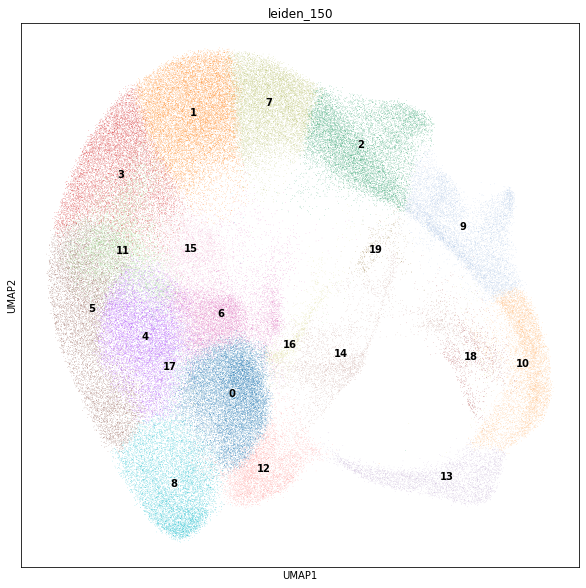

In [5]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150"], legend_loc="on data")

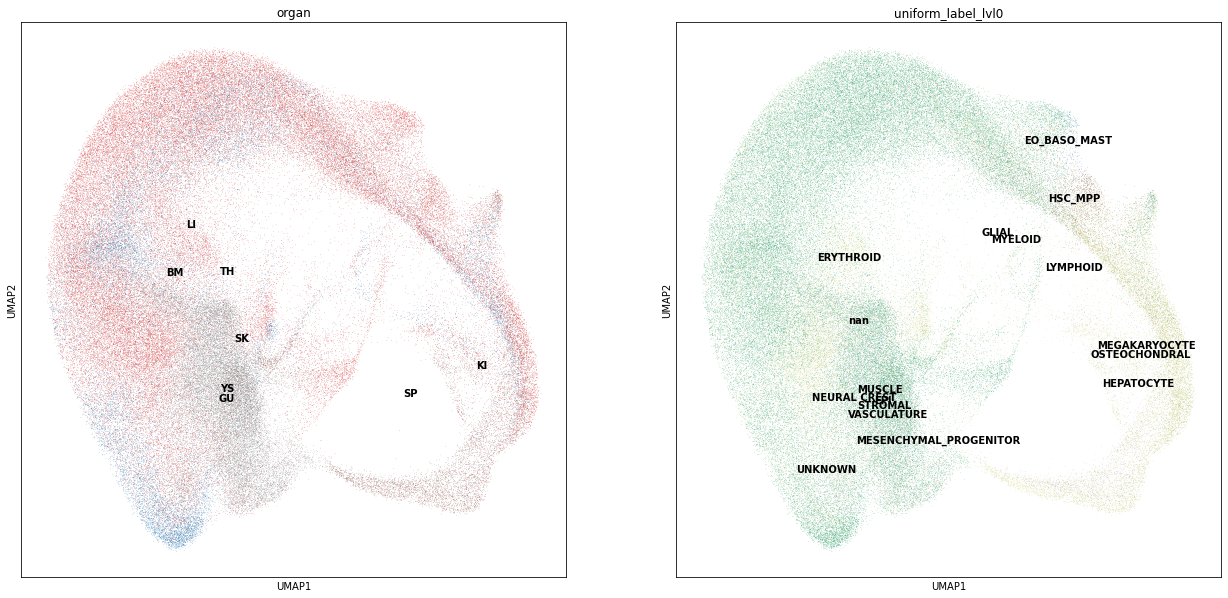

In [6]:
sc.pl.umap(adata, color=["organ", 'uniform_label_lvl0'], legend_loc="on data")

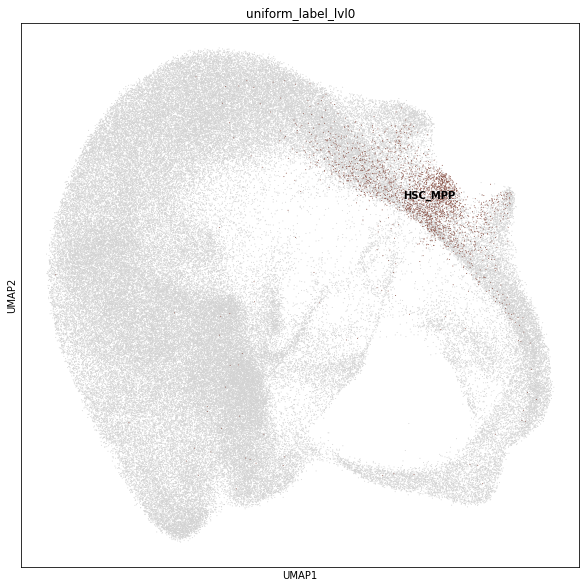

In [11]:
sc.pl.umap(adata, color=['uniform_label_lvl0'], legend_loc="on data", 
               groups=["HSC_MPP"], size=4)

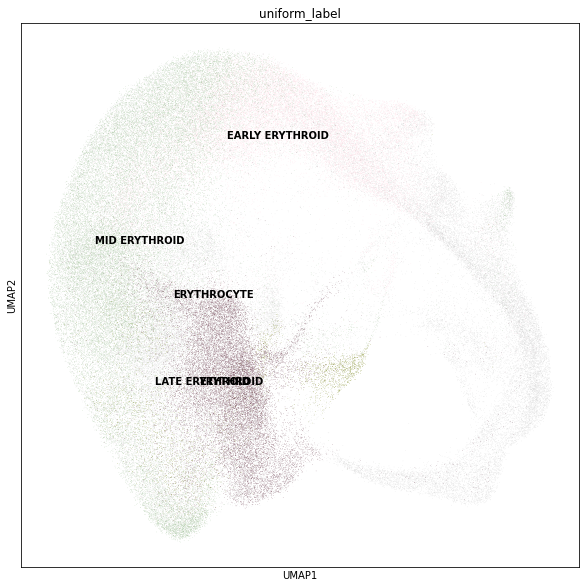

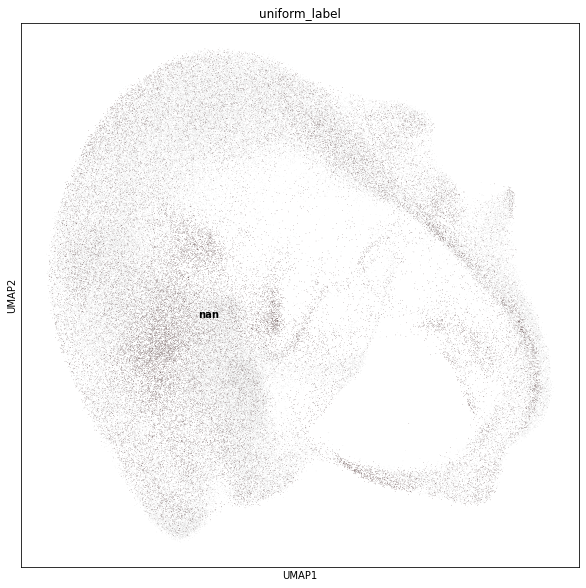

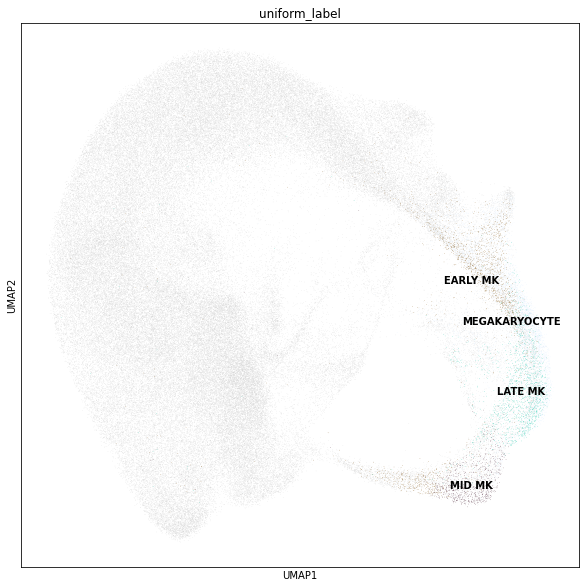

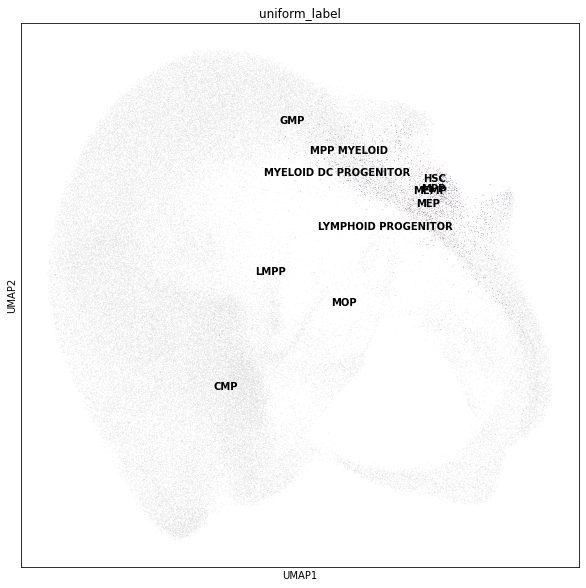

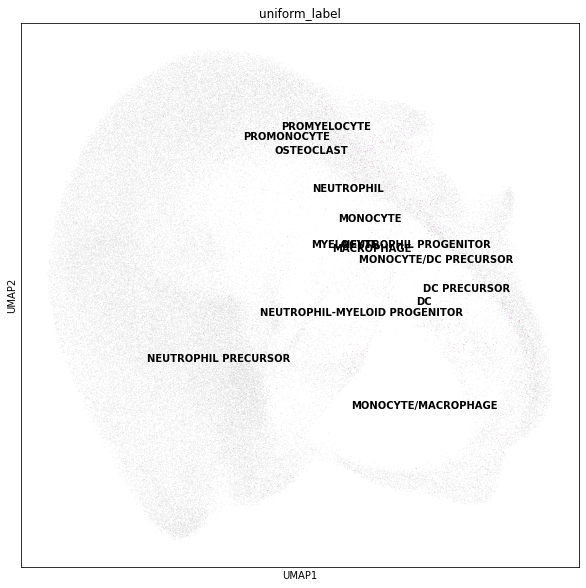

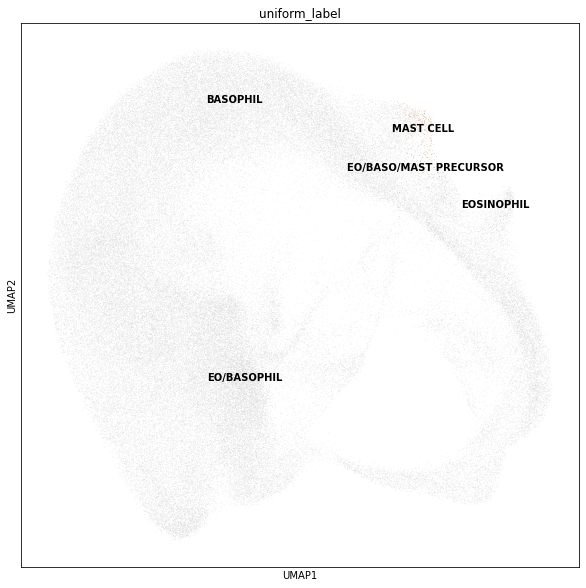

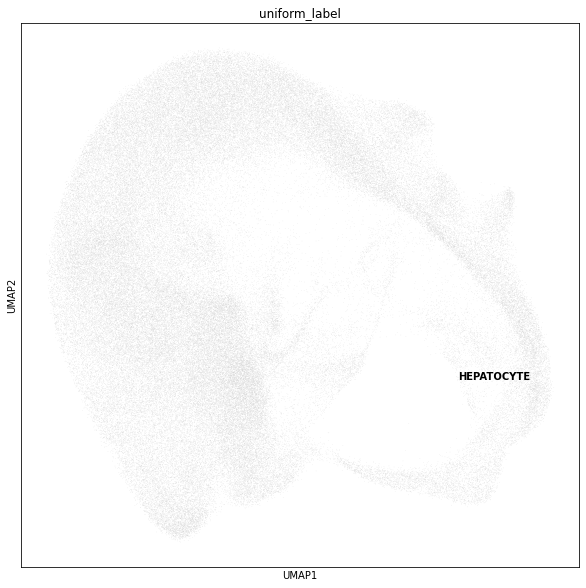

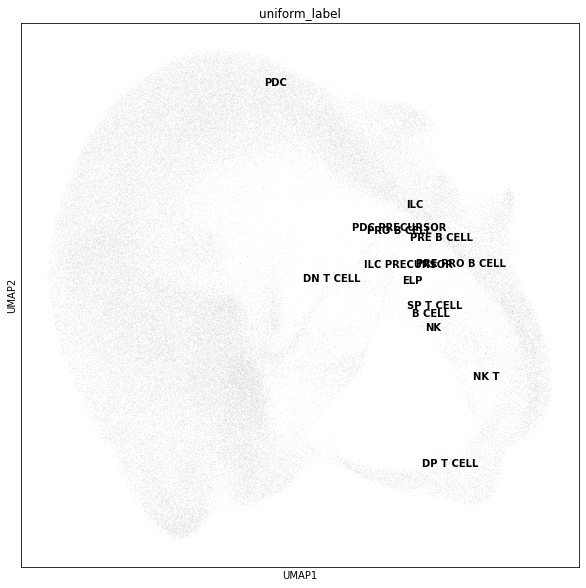

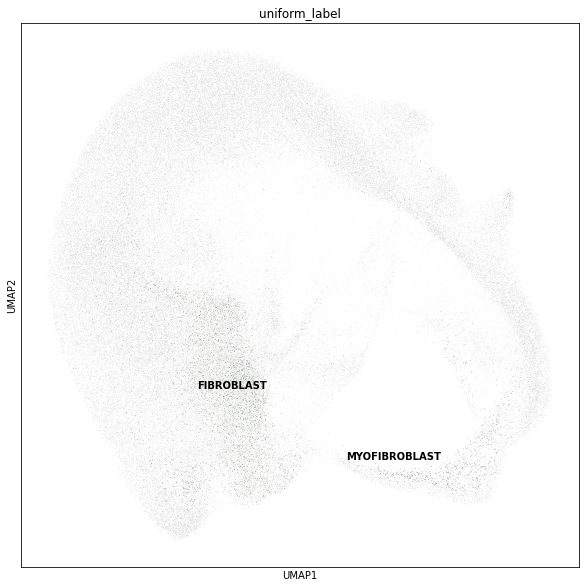

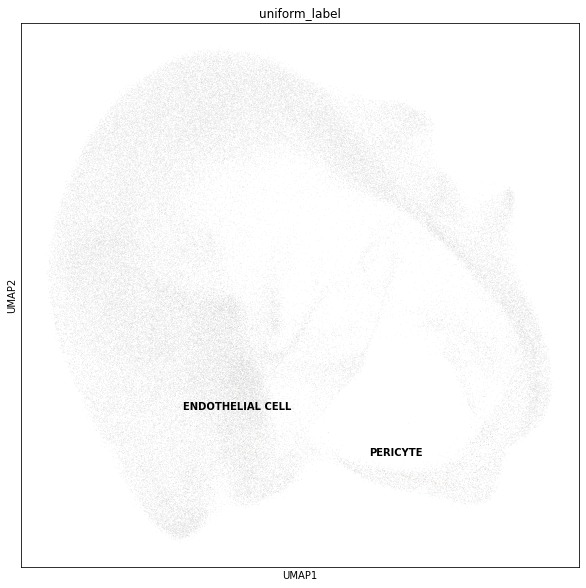

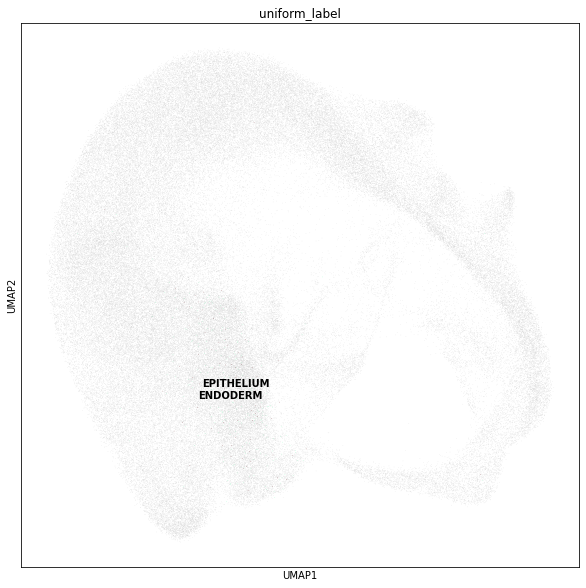

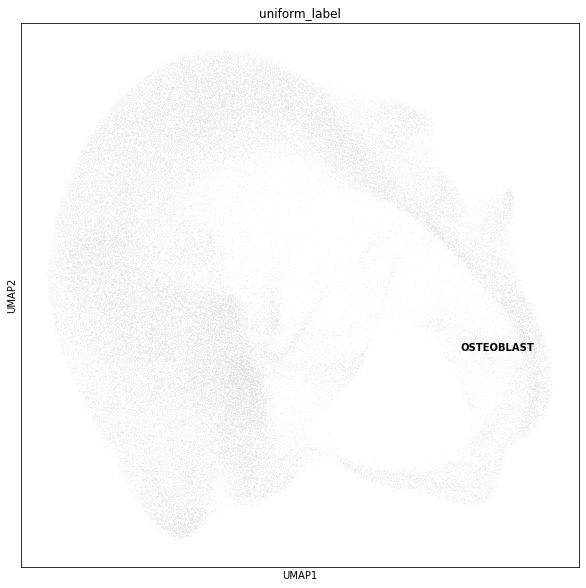

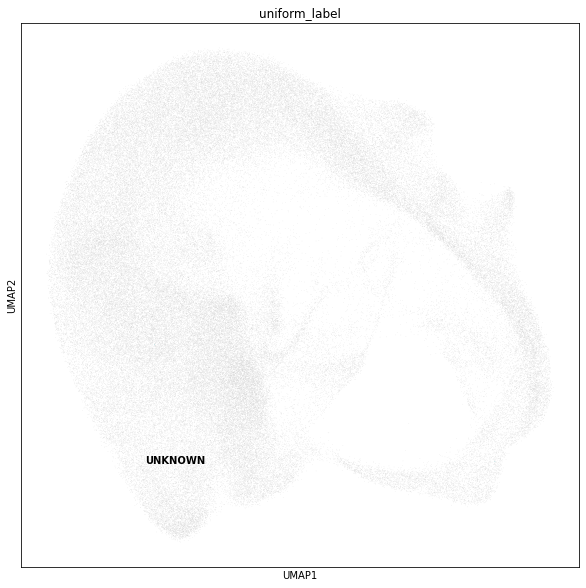

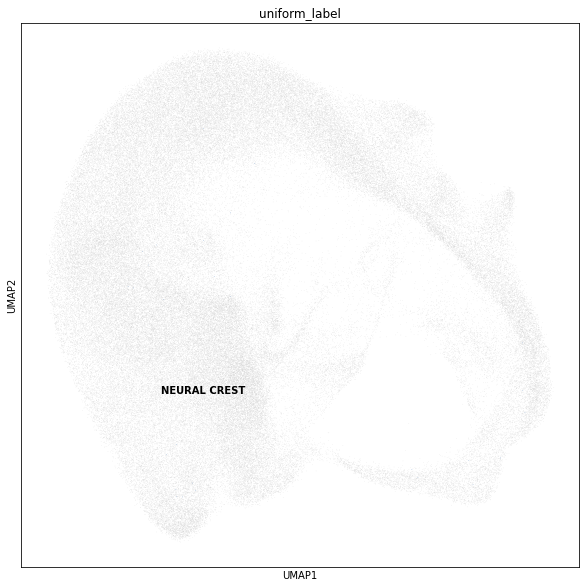

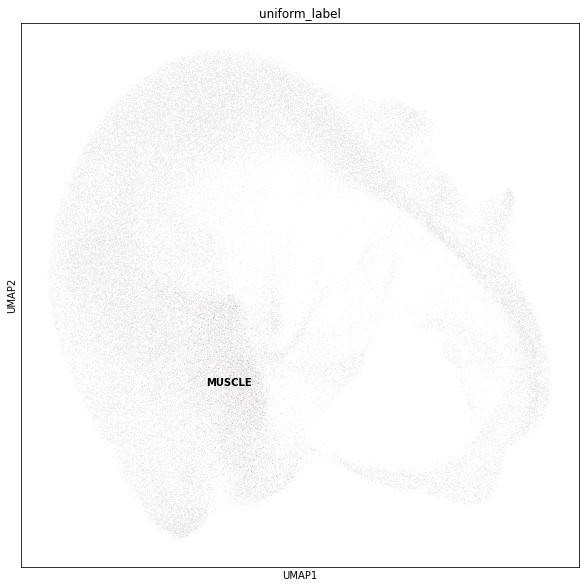

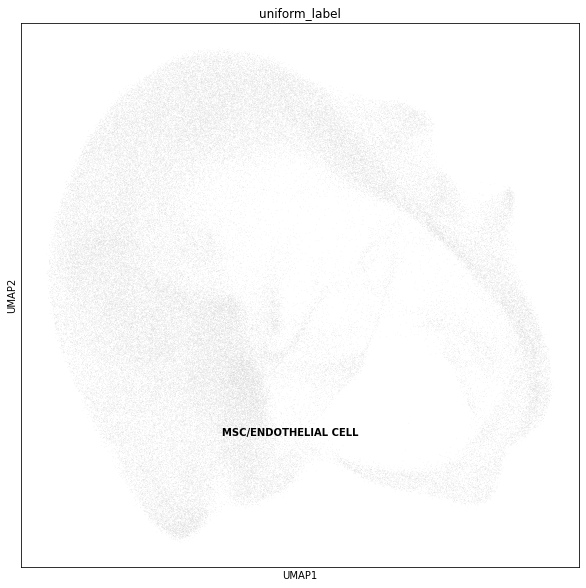

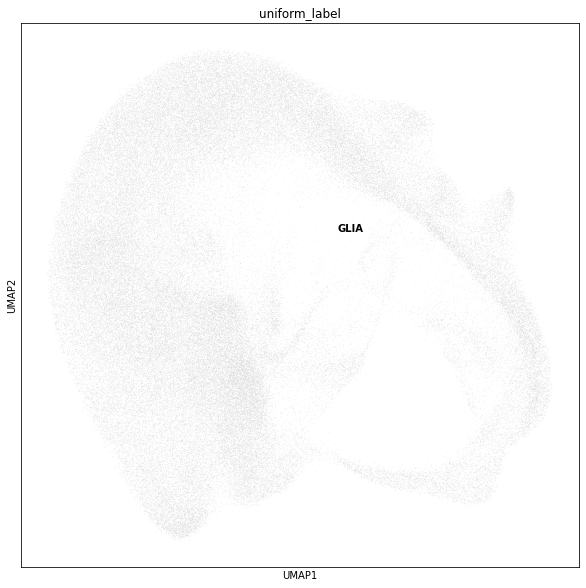

In [12]:
for o in adata.obs['uniform_label_lvl0'].unique():
    sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=adata.obs['uniform_label'][adata.obs['uniform_label_lvl0'] == o].unique())

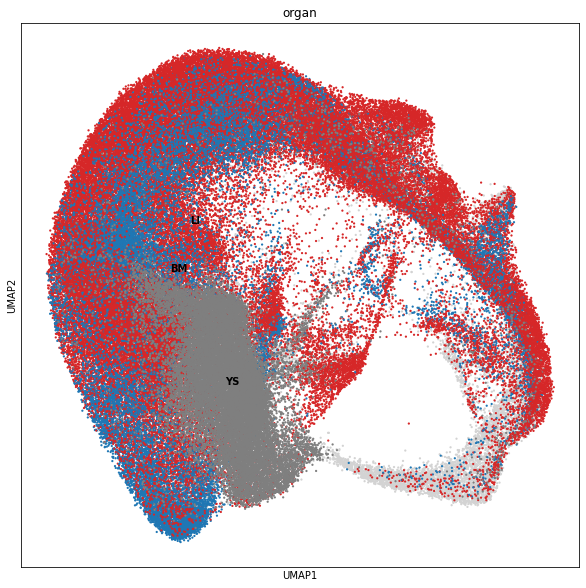

In [20]:
sc.pl.umap(adata, color=["organ"], groups=["YS","BM", "LI"], size=20, legend_loc="on data")

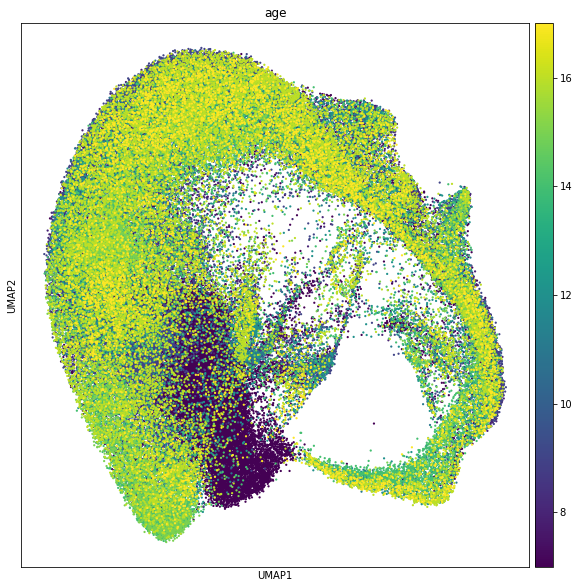

In [23]:
sc.pl.umap(adata, color=["age"],size=20, vmin=7)

In [41]:
hsc_df = adata.obs[adata.obs["uniform_label_lvl0"]=="HSC_MPP"]
hsc_df["n_cells"] = 1
hsc_df.groupby(["organ","age"]).sum("n_cells").reset_index().sort_values('n_cells', ascending=False)[0:20]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


organ  age   n_counts  n_genes      mito  doublet_scores  n_cells
64    SP   16  8284174.0  1373125  9.529628       14.345412      324
36    LI    9  4955491.0   872942  7.310250       13.272421      227
63    SP   15  3607113.0   671840  6.524280       23.957140      171
42    LI   16  3127012.0   584749  4.415983        8.294074      149
35    LI    8  3115736.0   530443  4.487328        5.790481      122
39    LI   12  2951338.0   512872  3.816669        6.897821      122
52    SK   15  2160642.0   428807  4.789769       16.837424      120
61    SP   12  2397516.0   417392  3.428462       13.617242      107
34    LI    7  2350549.0   411974  2.565346        6.079223      101
40    LI   14  1621499.0   317860  2.500554        4.910085       84
50    SK   12  1236659.0   262518  3.046337       10.984416       79
7     BM   14  2404438.0   389946  3.234684       11.793403       78
9     BM   16  2850852.0   427586  2.667938       10.715221       78
8     BM   15  2079985.0   346233  3.805129        8.417360       76
60    SP   11  1937798.0   295275  1.870959        6.772073       71
65    SP   17  2467347.0   355106  2.142899        4.054363       69
43    LI   17  1440636.0   266733  2.018522        3.755099       67
62    SP   14  1505365.0   244865  1.582755        5.738203       62
45    SK    7  1579914.0   266756  2.290315        7.078188       56
78    YS    7   407752.0    76067  0.992539        4.434199       37

### Annotate clusters using most frequent label 

In [17]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

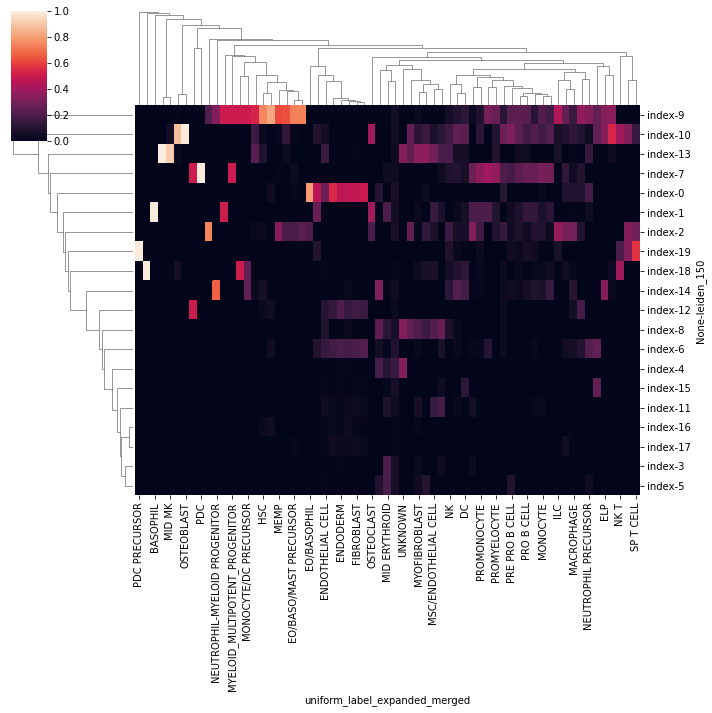

In [18]:
import seaborn as sns
sns.clustermap(cl_counts.T/cl_counts.sum(1))

... storing 'leiden_150_pred_label' as categorical


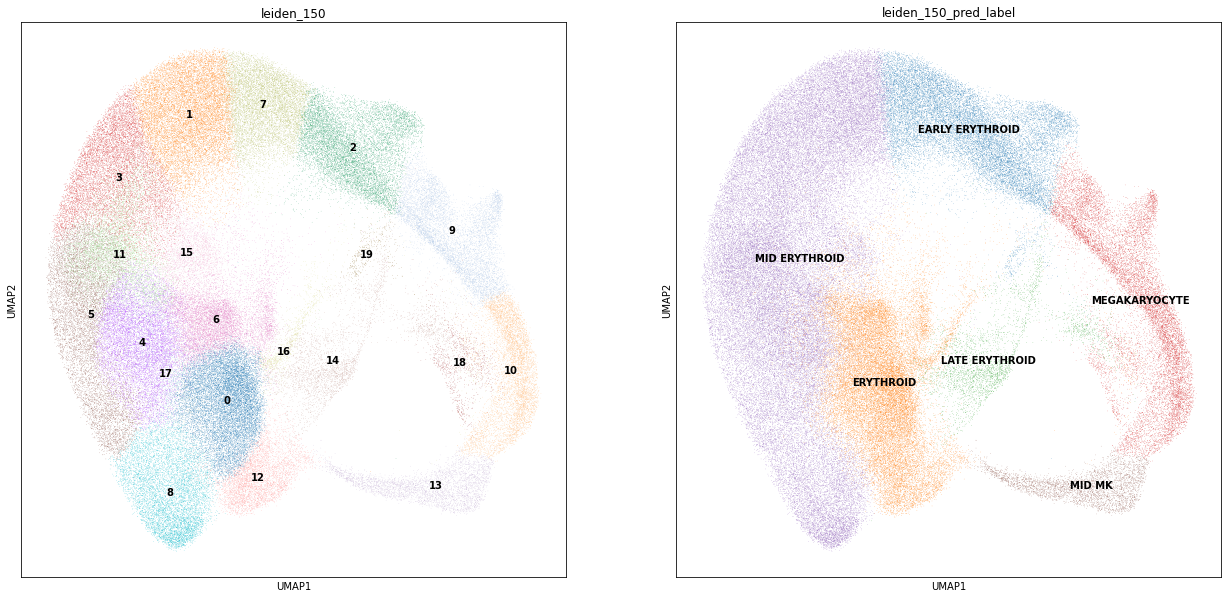

In [19]:
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")